In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockx-data-contest/StockX-Data-Contest-2019-3.csv
/kaggle/input/stockx/StockX-Data-Contest-2019-3.csv


# StockX Sneaker Price Regression

In this notebook, I will perform regression to predict the price of a given sneaker based on several factors such as order date, brand, sneaker name, sale price, and several others. This dataset is directly from StockX and was used for their 2019 data competition. 

### Description from StockX:

The data we’re giving you consists of a random sample of all Off-White x Nike and Yeezy 350 sales from between 9/1/2017 (the month that Off-White first debuted “The Ten” collection) and the present. There are 99,956 total sales in the data set; 27,794 Off-White sales, and 72,162 Yeezy sales. The sample consists of U.S. sales only.

To create this sample, we took a random, fixed percentage of StockX sales (X%) for each colorway, on each day, since September 2017. So, for each day the Off-White Jordan 1 was on the market, we randomly selected X% of its sale from each day. (It’s not important to know what X is; all that matters is that it’s a random sample, and that the same fixed X% of sales was selected from every day, for every sneaker).

To create this sample, we took a random, fixed percentage of StockX sales (X%) for each colorway, on each day, since September 2017. So, for each day the Off-White Jordan 1 was on the market, we randomly selected X% of its sale from each day. (It’s not important to know what X is; all that matters is that it’s a random sample, and that the same fixed X% of sales was selected from every day, for every sneaker).

We’ve included 8 variables for you to work with: Order Date, Brand, Sneaker Name, Sale Price ($), Retail Price ($), Release Date, Shoe Size, and Buyer State (the U.S. state the buyer shipped to). You can use whatever variables you want in the analysis; you can use 1 variable, or you can use all 8. And remember, every row in the spreadsheet represents an individual StockX sale. There are no averages or order counts; this is just a random sample of daily sales data.


# Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

In [3]:
# Reading in the data
original_data = pd.read_csv('../input/stockx/StockX-Data-Contest-2019-3.csv', header = 2)
df = original_data.copy()
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/2017,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/2016,11.0,California
1,9/1/2017,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/2016,11.0,California
2,9/1/2017,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/2016,11.0,California
3,9/1/2017,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/2016,11.5,Kentucky
4,9/1/2017,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/2017,11.0,Rhode Island


In [4]:
df.shape

(99956, 8)

In [5]:
df.dtypes

Order Date       object
Brand            object
Sneaker Name     object
Sale Price       object
Retail Price     object
Release Date     object
Shoe Size       float64
Buyer Region     object
dtype: object

In [6]:
df.describe()

,Shoe Size
count,99956.000000
mean,9.344181
std,2.329588
min,3.500000
25%,8.000000
50%,9.500000
75%,11.000000
max,17.000000


In [7]:
# Checking for null values
nulls = pd.concat([df.isnull().sum()], axis=1)
nulls[nulls.sum(axis=1) > 0]

,0


In [8]:
# Change 'order date' dtype
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/2016,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/2016,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/2016,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/2016,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/2017,11.0,Rhode Island


In [9]:
# Change 'release date' dtype
df['Release Date'] = pd.to_datetime(df['Release Date'], format='%m/%d/%Y')
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2017-02-11,11.0,Rhode Island


In [10]:
# Remove - from sneaker name
df['Sneaker Name'] = df['Sneaker Name'].apply(lambda x: x.replace('-', ' '))
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,"$1,097",$220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,$685,$220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,$690,$220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,"$1,075",$220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,$828,$220,2017-02-11,11.0,Rhode Island


In [11]:
# Remove $ and comma from sale price
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace('$', ''))
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace(',', ''))
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097,$220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685,$220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690,$220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075,$220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828,$220,2017-02-11,11.0,Rhode Island


In [12]:
# Remove $ from retail price
df['Retail Price'] = df['Retail Price'].apply(lambda x: x.replace('$', ''))
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828,220,2017-02-11,11.0,Rhode Island


In [13]:
df.dtypes

Order Date      datetime64[ns]
Brand                   object
Sneaker Name            object
Sale Price              object
Retail Price            object
Release Date    datetime64[ns]
Shoe Size              float64
Buyer Region            object
dtype: object

In [14]:
# Converting some object columns into numerical columns
obj_cols = ['Sale Price','Retail Price']
for col in obj_cols:
    df[str(col)] = pd.to_numeric(df[str(col)])

In [15]:
df.dtypes

Order Date      datetime64[ns]
Brand                   object
Sneaker Name            object
Sale Price               int64
Retail Price             int64
Release Date    datetime64[ns]
Shoe Size              float64
Buyer Region            object
dtype: object

# EDA

In [16]:
df.columns

Index(['Order Date', 'Brand', 'Sneaker Name', 'Sale Price', 'Retail Price',
       'Release Date', 'Shoe Size', 'Buyer Region'],
      dtype='object')

In [17]:
# Make Bought For Less Than Retail column
df['Bought for Less Than Retail'] = df['Sale Price'] < df['Retail Price']
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Bought for Less Than Retail
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097,220,2016-09-24,11.0,California,False
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685,220,2016-11-23,11.0,California,False
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690,220,2016-11-23,11.0,California,False
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075,220,2016-11-23,11.5,Kentucky,False
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828,220,2017-02-11,11.0,Rhode Island,False


In [18]:
# Make Bought For Retail column
df['Bought for Retail'] = df['Sale Price'] == df['Retail Price']
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Bought for Less Than Retail,Bought for Retail
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097,220,2016-09-24,11.0,California,False,False
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685,220,2016-11-23,11.0,California,False,False
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690,220,2016-11-23,11.0,California,False,False
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075,220,2016-11-23,11.5,Kentucky,False,False
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828,220,2017-02-11,11.0,Rhode Island,False,False


In [19]:
# Make Bought For More Than Retail column
df['Bought for More Than Retail'] = df['Sale Price'] > df['Retail Price']
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Bought for Less Than Retail,Bought for Retail,Bought for More Than Retail
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097,220,2016-09-24,11.0,California,False,False,True
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685,220,2016-11-23,11.0,California,False,False,True
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690,220,2016-11-23,11.0,California,False,False,True
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075,220,2016-11-23,11.5,Kentucky,False,False,True
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828,220,2017-02-11,11.0,Rhode Island,False,False,True


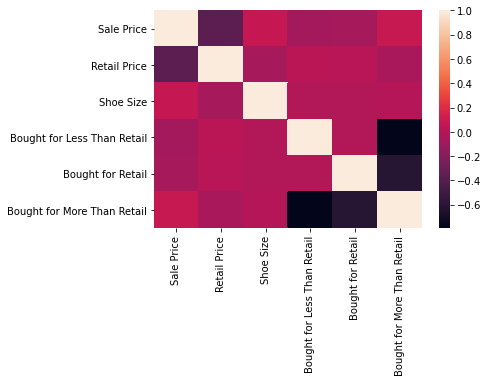

In [20]:
# Genereal numeric correlations
# Analyze trend between shoe size and sale price
# Analyze trend between sale price and retail price
correlations = df.corr()
sns.heatmap(correlations)

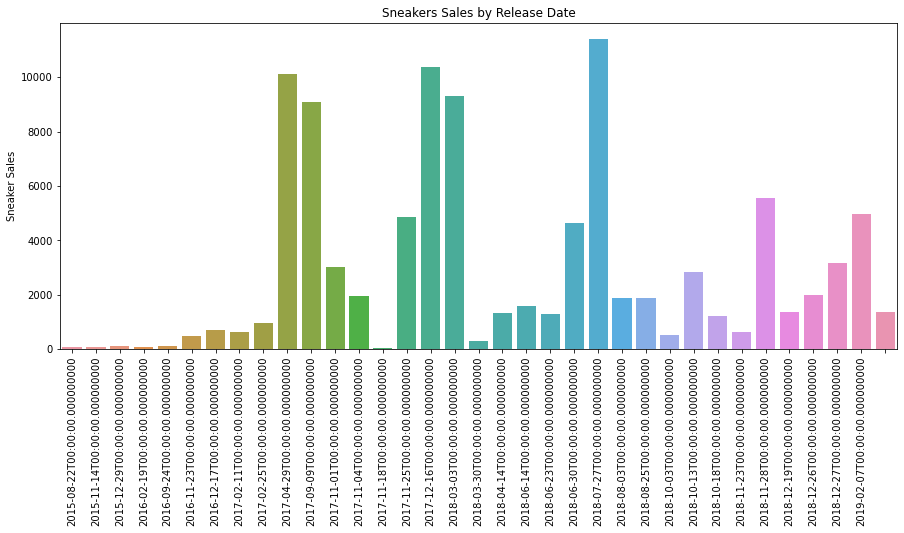

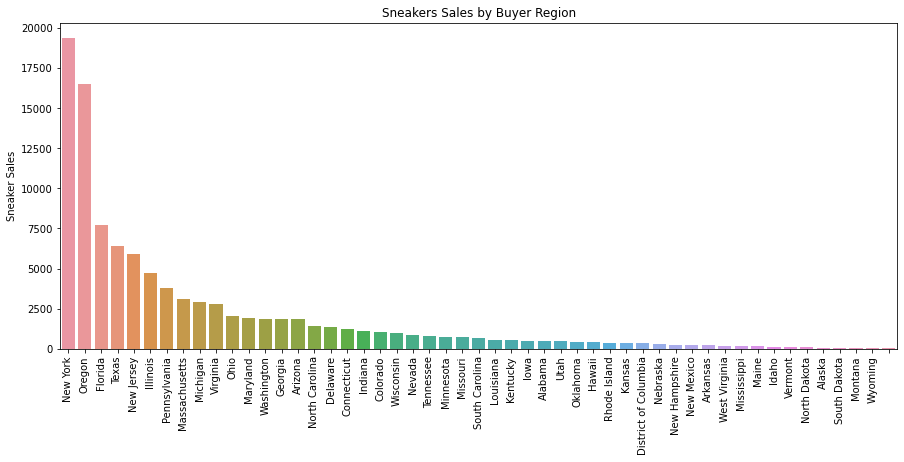

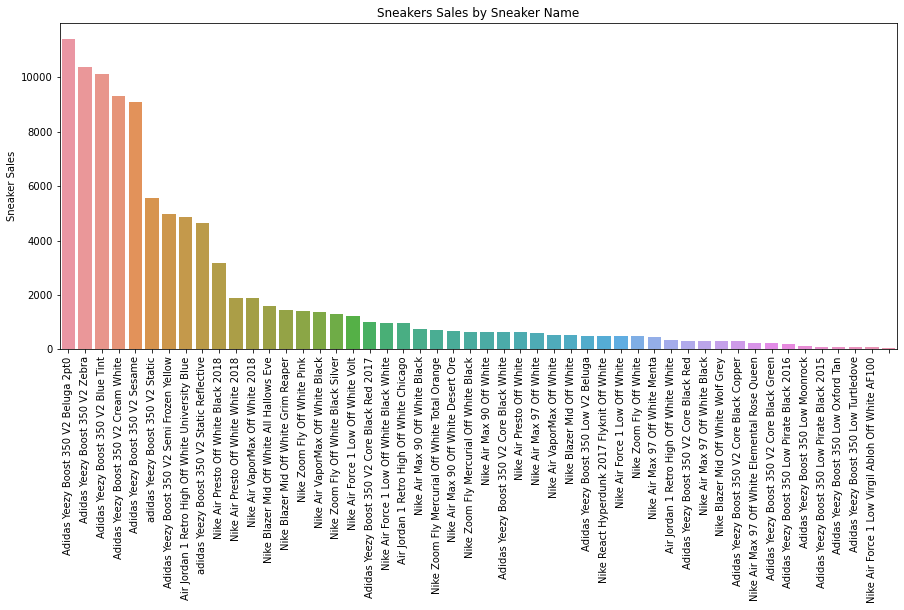

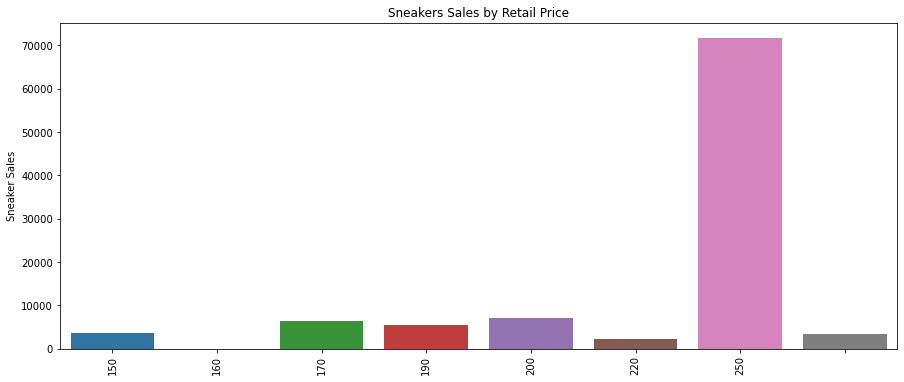

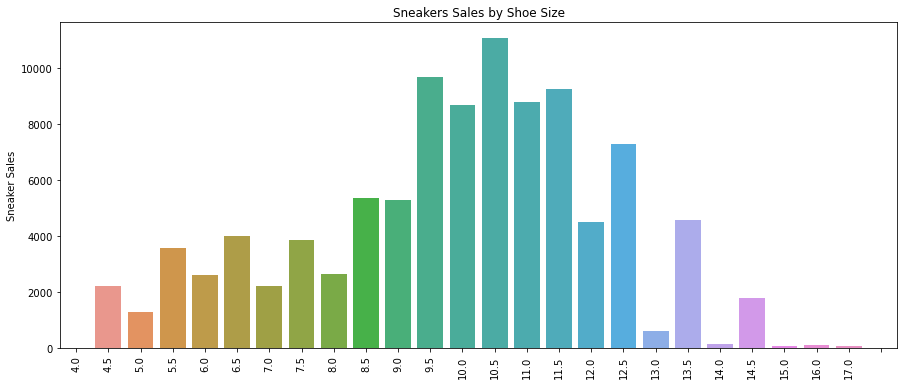

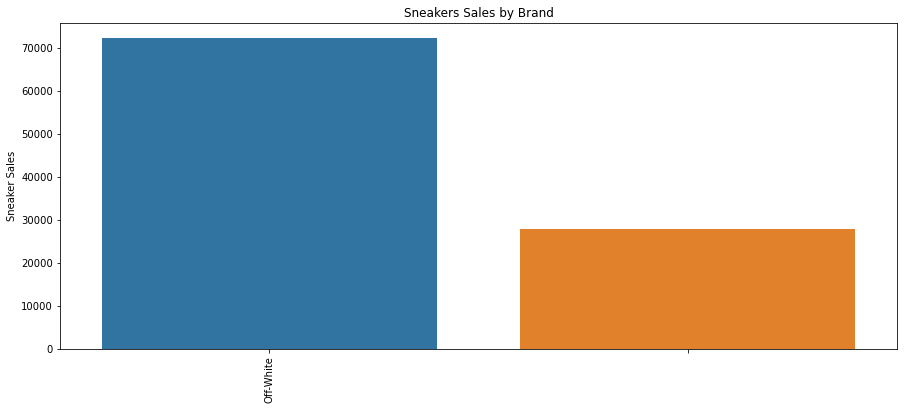

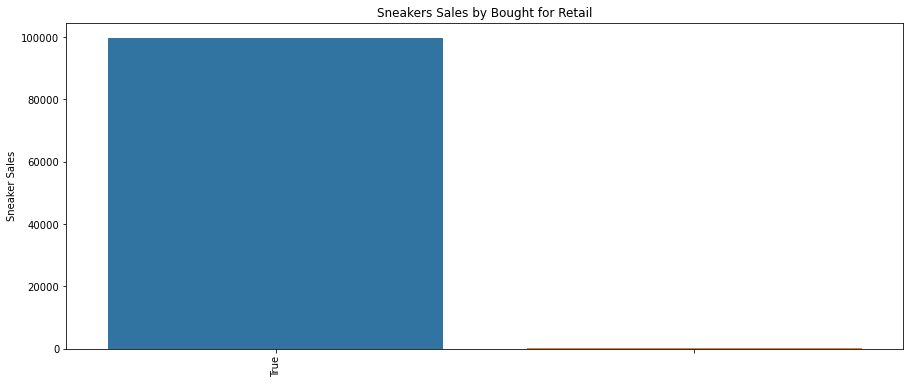

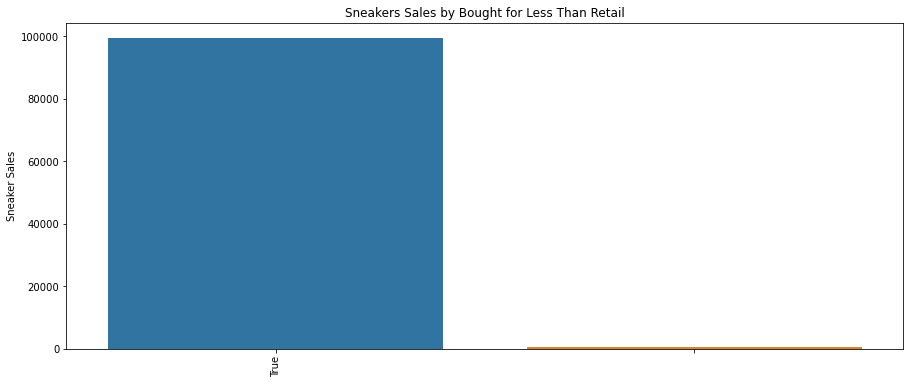

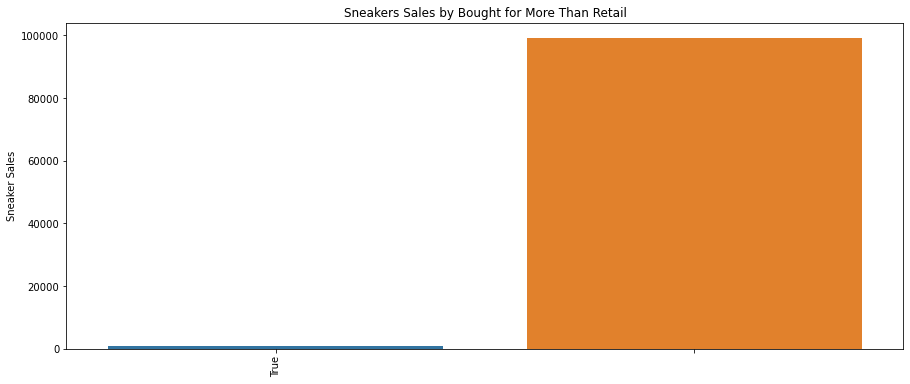

In [21]:
# Release date, buyer region, and sneaker name, retail price, shoe size, and brand distribution analysis
df_cat = ['Release Date', 'Buyer Region', 'Sneaker Name', 'Retail Price', 'Shoe Size', 'Brand', 'Bought for Retail', 'Bought for Less Than Retail', 'Bought for More Than Retail' ]
for cat in df_cat:
    cat_num = df[str(cat)].value_counts()
    plt.figure(figsize=(15,6))
    chart = sns.barplot(x = cat_num.index, y= cat_num)
    chart.set_title("Sneakers Sales by %s" % (cat))
    plt.ylabel("Sneaker Sales")
    chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.show(15)

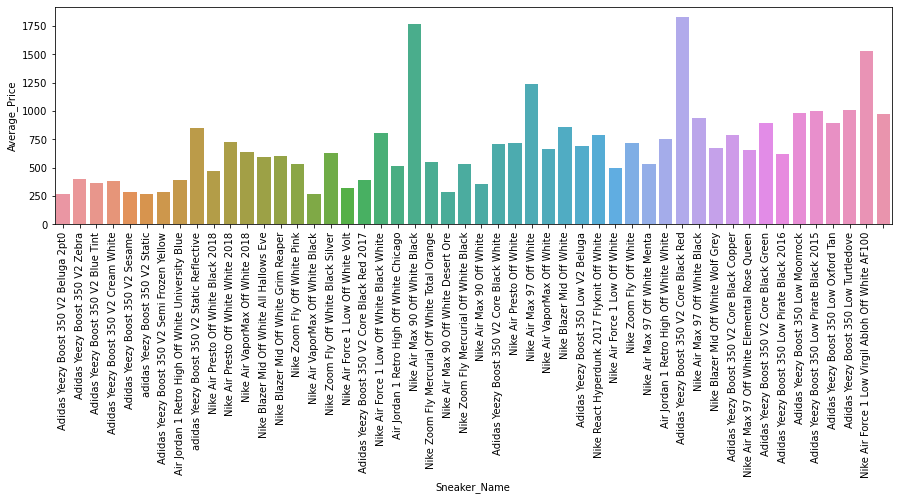

In [22]:
# Analyze trend between Sneaker Name & Sale price
# Create average retail price df
bruh = df[['Sneaker Name', 'Sale Price']]

# Clean up this list
sneakernames = ['adidas Yeezy Boost 350 V2 Butter',
       'Adidas Yeezy Boost 350 V2 Beluga 2pt0',
       'Adidas Yeezy Boost 350 V2 Zebra',
       'Adidas Yeezy Boost 350 V2 Blue Tint',
       'Adidas Yeezy Boost 350 V2 Cream White',
       'Adidas Yeezy Boost 350 V2 Sesame', 'adidas Yeezy Boost 350 V2 Static',
       'Adidas Yeezy Boost 350 V2 Semi Frozen Yellow',
       'Air Jordan 1 Retro High Off White University Blue',
       'adidas Yeezy Boost 350 V2 Static Reflective',
       'Nike Air Presto Off White Black 2018',
       'Nike Air Presto Off White White 2018',
       'Nike Air VaporMax Off White 2018',
       'Nike Blazer Mid Off White All Hallows Eve',
       'Nike Blazer Mid Off White Grim Reaper', 'Nike Zoom Fly Off White Pink',
       'Nike Air VaporMax Off White Black',
       'Nike Zoom Fly Off White Black Silver',
       'Nike Air Force 1 Low Off White Volt',
       'Adidas Yeezy Boost 350 V2 Core Black Red 2017',
       'Nike Air Force 1 Low Off White Black White',
       'Air Jordan 1 Retro High Off White Chicago',
       'Nike Air Max 90 Off White Black',
       'Nike Zoom Fly Mercurial Off White Total Orange',
       'Nike Air Max 90 Off White Desert Ore',
       'Nike Zoom Fly Mercurial Off White Black', 'Nike Air Max 90 Off White',
       'Adidas Yeezy Boost 350 V2 Core Black White',
       'Nike Air Presto Off White', 'Nike Air Max 97 Off White',
       'Nike Air VaporMax Off White', 'Nike Blazer Mid Off White',
       'Adidas Yeezy Boost 350 Low V2 Beluga',
       'Nike React Hyperdunk 2017 Flyknit Off White',
       'Nike Air Force 1 Low Off White', 'Nike Zoom Fly Off White',
       'Nike Air Max 97 Off White Menta',
       'Air Jordan 1 Retro High Off White White',
       'Adidas Yeezy Boost 350 V2 Core Black Red',
       'Nike Air Max 97 Off White Black',
       'Nike Blazer Mid Off White Wolf Grey',
       'Adidas Yeezy Boost 350 V2 Core Black Copper',
       'Nike Air Max 97 Off White Elemental Rose Queen',
       'Adidas Yeezy Boost 350 V2 Core Black Green',
       'Adidas Yeezy Boost 350 Low Pirate Black 2016',
       'Adidas Yeezy Boost 350 Low Moonrock',
       'Adidas Yeezy Boost 350 Low Pirate Black 2015',
       'Adidas Yeezy Boost 350 Low Oxford Tan',
       'Adidas Yeezy Boost 350 Low Turtledove',
       'Nike Air Force 1 Low Virgil Abloh Off White AF100'
       ]
avgs = []
for name in sneakernames:
    shoerow = bruh.loc[bruh['Sneaker Name'] == name]
    avgs.append(shoerow.mean()[0])
AvgPrice = pd.Series(avgs)
SneakerName = pd.Series(sneakernames)
avgprice_df = pd.DataFrame(columns = ['Sneaker_Name', 'Average_Price'])
avgprice_df['Sneaker_Name'] = SneakerName
avgprice_df['Average_Price'] = AvgPrice

# Crerating visual of average shoe price
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.barplot(x = avgprice_df['Sneaker_Name'] , y= avgprice_df['Average_Price'])
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

In [23]:
# Find average sale price by brand
avgs_2 = []
bds = df[['Brand', 'Sale Price']]
brands = [' Yeezy', 'Off-White']
for brand in brands:
    brandrow = bds.loc[bds['Brand'] == str(brand)]
    avgs_2.append(brandrow['Sale Price'].mean())
print('Yeezy average price: $' + str(avgs_2[0]))
print('Off-White average price: $' + str(avgs_2[1]))

Yeezy average price: $360.03255175854326
Off-White average price: $671.4812909260992


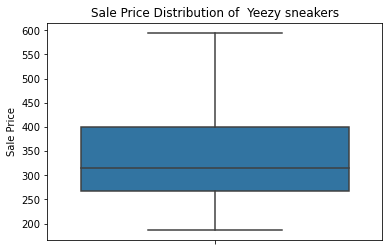

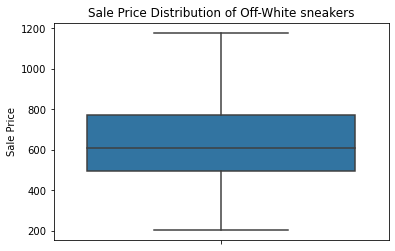

In [24]:
# Create boxplot distribution of sales price by brand
for brand in brands:
    brandrow = bds.loc[bds['Brand'] == str(brand)]
    chart = sns.boxplot(y=brandrow["Sale Price"], showfliers = False)
    chart.set_title("Sale Price Distribution of %s sneakers" % (brand))
    plt.show()

In [25]:
# Analyze trend between Sales Price and Order Date
# Find average sale price per day
dts = df[['Order Date', 'Sale Price']]
uniq_ord_dates = df['Order Date'].value_counts().index.tolist()
avg_3 = []

for date in uniq_ord_dates:
    daterow = dts.loc[dts['Order Date'] == str(date)]
    avg_3.append(daterow['Sale Price'].mean())

unq_dates = pd.Series(uniq_ord_dates)
date_avgs = pd.Series(avg_3)
dateprice_df = pd.DataFrame(columns = ['Order_date', 'Average_Price'])
dateprice_df['Order_date'] = unq_dates.sort_values(ascending = True)
dateprice_df['Average_Price'] = date_avgs
dateprice_df.head()

,Order_date,Average_Price
482,2017-09-01,653.000000
514,2017-09-02,649.600000
505,2017-09-03,672.437500
501,2017-09-04,623.764706
486,2017-09-05,648.772727


Text(0.5, 1.0, 'Average Daily Sale Price Over time')

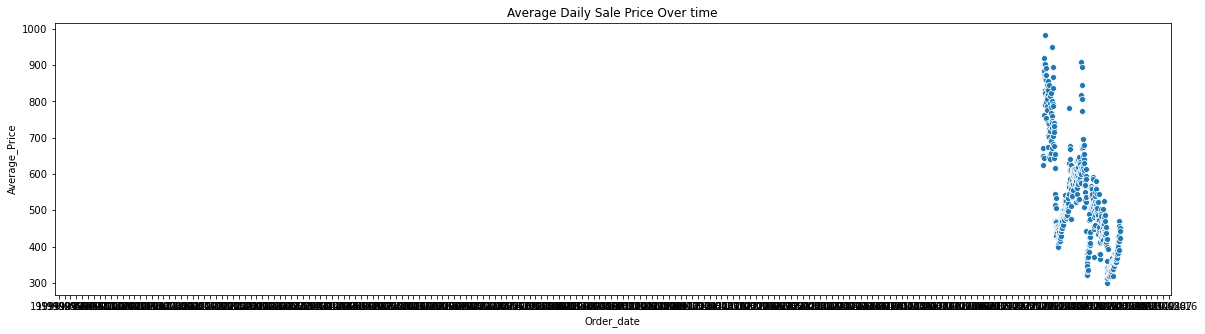

In [26]:
# Create visualization of Average Sale Price Over time
fig_dims = (20, 5)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.scatterplot(x="Order_date", y="Average_Price", data=dateprice_df)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(40))
chart.set_title("Average Daily Sale Price Over time")

In [27]:
# Finding Average Sale Price on Release Dates Over Time
dts = df[['Release Date', 'Sale Price']]
uniq_rel_dates = df['Release Date'].value_counts().index.tolist()
avg_4 = []

for date in uniq_rel_dates:
    daterow = dts.loc[dts['Release Date'] == str(date)]
    avg_4.append(daterow['Sale Price'].mean())

unq_dates = pd.Series(uniq_rel_dates)
date_avgs = pd.Series(avg_4)
dateprice_df_2 = pd.DataFrame(columns = ['Release_date', 'Average_Price'])
dateprice_df_2['Release_date'] = unq_dates.sort_values(ascending = True)
dateprice_df_2['Average_Price'] = date_avgs
dateprice_df_2.head()

,Release_date,Average_Price
33,2015-06-27,1531.661765
31,2015-08-22,895.094737
30,2015-11-14,996.710000
32,2015-12-29,1011.514286
29,2016-02-19,984.237705


Text(0.5, 1.0, 'Average Sale Price by Buyer Region')

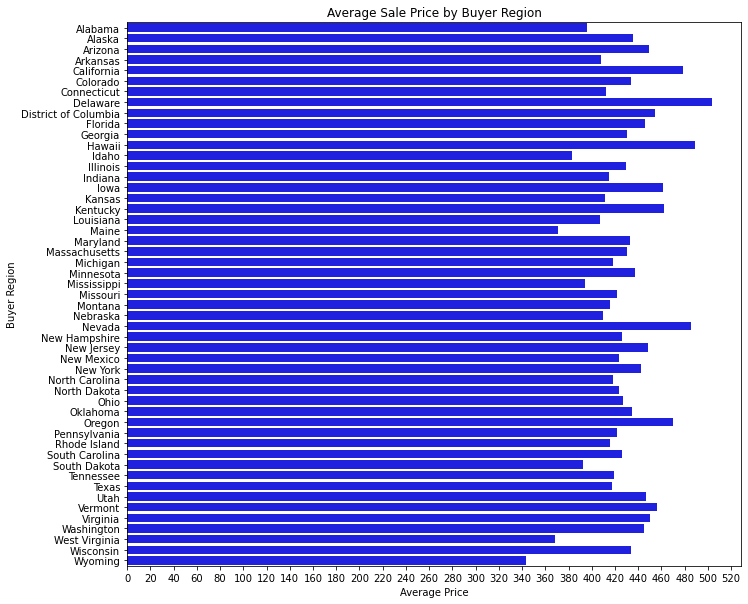

In [28]:
# Analyze trend between buyer region and sale price

brg = df[['Buyer Region', 'Sale Price']]
unq_brgs = df['Buyer Region'].value_counts().index.tolist()
avg_5 = []

for region in unq_brgs:
    regionrow = brg.loc[brg['Buyer Region'] == str(region)]
    avg_5.append(regionrow['Sale Price'].mean())

unq_regions = pd.Series(unq_brgs)
region_avgs = pd.Series(avg_5)
regionprice_df = pd.DataFrame(columns = ['Buyer Region', 'Average Price'])
regionprice_df['Buyer Region'] = unq_regions.sort_values(ascending = True)
regionprice_df['Average Price'] = region_avgs

fig_dims = (11, 10)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.barplot(x="Average Price", y="Buyer Region", data=regionprice_df, color="b")
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
chart.set_title("Average Sale Price by Buyer Region")

# Linear Regression

### Quick Data Cleaning

In [29]:
# Renaming columns to get rid of spaces 
df = df.rename(columns={
    "Order Date": "Order_date",
    "Sneaker Name": "Sneaker_Name",
    "Sale Price": "Sale_Price",
    "Retail Price": "Retail_Price",
    "Release Date": "Release_Date",
    "Shoe Size": "Shoe_Size",
    "Buyer Region": "Buyer_Region"
    })

In [30]:
# Converting dates into numericals
import datetime as dt

df['Order_date'] = pd.to_datetime(df['Order_date'])
df['Order_date']=df['Order_date'].map(dt.datetime.toordinal)

df['Release_Date'] = pd.to_datetime(df['Release_Date'])
df['Release_Date']=df['Release_Date'].map(dt.datetime.toordinal)

In [31]:
# Getting spltis
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

X = df.drop(['Sale_Price', 'Bought for More Than Retail', 'Bought for Less Than Retail', 'Bought for Retail'], axis=1)
y = df.Sale_Price
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [32]:
# Converting categorical data to numerical
from sklearn.preprocessing import OneHotEncoder

object_cols = ['Sneaker_Name', 'Buyer_Region', 'Brand']
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Adding the column names after one hot encoding
OH_cols_train.columns = OH_encoder.get_feature_names(object_cols)
OH_cols_valid.columns = OH_encoder.get_feature_names(object_cols)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

### Model 1

In [33]:
# Starting linear regression
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(OH_X_train,y_train)

LinearRegression()

In [34]:
# Looking at y-int
print(lm.intercept_)

12789891964398.3


In [35]:
# Looking at coefficient scores of each variable
coeff_df = pd.DataFrame(lm.coef_, OH_X_train.columns,columns=['Coefficient'])
ranked_coeff = coeff_df.sort_values("Coefficient", ascending = False)
ranked_coeff

,Coefficient
Sneaker_Name_Nike Air VaporMax Off White 2018,2.250787e+10
Sneaker_Name_Nike Air VaporMax Off White Black,2.224883e+10
Sneaker_Name_Nike Air VaporMax Off White,1.876035e+10
Sneaker_Name_Nike Zoom Fly Mercurial Off White Black,7.353342e+09
Sneaker_Name_Nike Zoom Fly Mercurial Off White Total Orange,7.353342e+09
...,...
Sneaker_Name_Adidas Yeezy Boost 350 Low Pirate Black 2016,-2.106737e+10
Sneaker_Name_Adidas Yeezy Boost 350 Low Oxford Tan,-2.196539e+10
Sneaker_Name_Adidas Yeezy Boost 350 Low Moonrock,-2.274253e+10
Sneaker_Name_Adidas Yeezy Boost 350 Low Pirate Black 2015,-2.419318e+10


In [36]:
# Storing predictions and running evaluation metrics
predictions = lm.predict(OH_X_valid)
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))

MAE: 60.50451948357468
MSE: 10909.620647445112
RMSE: 104.44912947193534


### Model 2

In [37]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
lm = LinearRegression()
lm.fit(OH_X_train,y_train)
rfe = RFE(lm, 10)
rfe = rfe.fit(OH_X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [39]:
list(zip(OH_X_train.columns,rfe.support_,rfe.ranking_))

[('Order_date', False, 98),
 ('Retail_Price', False, 96),
 ('Release_Date', False, 95),
 ('Shoe_Size', False, 97),
 ('Sneaker_Name_Adidas Yeezy Boost 350 Low Moonrock', False, 92),
 ('Sneaker_Name_Adidas Yeezy Boost 350 Low Oxford Tan', False, 93),
 ('Sneaker_Name_Adidas Yeezy Boost 350 Low Pirate Black 2015', False, 89),
 ('Sneaker_Name_Adidas Yeezy Boost 350 Low Pirate Black 2016', False, 91),
 ('Sneaker_Name_Adidas Yeezy Boost 350 Low Turtledove', False, 94),
 ('Sneaker_Name_Adidas Yeezy Boost 350 Low V2 Beluga', False, 87),
 ('Sneaker_Name_Adidas Yeezy Boost 350 V2 Beluga 2pt0', False, 82),
 ('Sneaker_Name_Adidas Yeezy Boost 350 V2 Blue Tint', False, 80),
 ('Sneaker_Name_Adidas Yeezy Boost 350 V2 Core Black Copper', False, 85),
 ('Sneaker_Name_Adidas Yeezy Boost 350 V2 Core Black Green', False, 84),
 ('Sneaker_Name_Adidas Yeezy Boost 350 V2 Core Black Red', False, 90),
 ('Sneaker_Name_Adidas Yeezy Boost 350 V2 Core Black Red 2017', False, 88),
 ('Sneaker_Name_Adidas Yeezy Boost 350

In [40]:
X_train_rfe = OH_X_train[OH_X_train.columns[rfe.support_]]
X_train_rfe

,Buyer_Region_Alabama,Buyer_Region_Arkansas,Buyer_Region_Idaho,Buyer_Region_Louisiana,Buyer_Region_Maine,Buyer_Region_Mississippi,Buyer_Region_New Mexico,Buyer_Region_South Dakota,Buyer_Region_West Virginia,Buyer_Region_Wyoming
50136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
80688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14742,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    model = sm.OLS(y, X)
    results = model.fit() # fitting the model
    print(results.summary()) # model summary
    return X
    
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [42]:
X_train_new = build_model(OH_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:             Sale_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     3997.
Date:                Sun, 06 Sep 2020   Prob (F-statistic):               0.00
Time:                        05:34:08   Log-Likelihood:            -4.8461e+05
No. Observations:               79964   AIC:                         9.694e+05
Df Residuals:                   79862   BIC:                         9.704e+05
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [43]:
checkVIF(X_train_new)

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
54,Sneaker_Name_adidas Yeezy Boost 350 V2 Static ...,inf
81,Buyer_Region_Montana,inf
79,Buyer_Region_Mississippi,inf
78,Buyer_Region_Minnesota,inf
77,Buyer_Region_Michigan,inf
...,...,...
31,Sneaker_Name_Nike Air Max 90 Off White Desert Ore,inf
2,Retail_Price,inf
1,Order_date,2.19
4,Shoe_Size,1.06


### Model 2

In [44]:
X_train_new = X_train_new.drop(['Sneaker_Name_Adidas Yeezy Boost 350 V2 Core Black Green',
       'Sneaker_Name_Nike Air Force 1 Low Off White',
       'Sneaker_Name_Nike Air Max 90 Off White',
       'Sneaker_Name_Nike Air VaporMax Off White Black',
       'Buyer_Region_Alabama', 'Buyer_Region_Alaska', 'Buyer_Region_Arkansas',
       'Buyer_Region_Colorado', 'Buyer_Region_Connecticut',
       'Buyer_Region_Delaware', 'Buyer_Region_District of Columbia',
       'Buyer_Region_Georgia', 'Buyer_Region_Hawaii', 'Buyer_Region_Idaho',
       'Buyer_Region_Illinois', 'Buyer_Region_Indiana', 'Buyer_Region_Iowa',
       'Buyer_Region_Kansas', 'Buyer_Region_Louisiana', 'Buyer_Region_Maine',
       'Buyer_Region_Massachusetts', 'Buyer_Region_Michigan',
       'Buyer_Region_Minnesota', 'Buyer_Region_Mississippi',
       'Buyer_Region_Missouri', 'Buyer_Region_Montana',
       'Buyer_Region_Nebraska', 'Buyer_Region_Nevada',
       'Buyer_Region_New Hampshire', 'Buyer_Region_New Jersey',
       'Buyer_Region_New Mexico', 'Buyer_Region_New York',
       'Buyer_Region_North Carolina', 'Buyer_Region_North Dakota',
       'Buyer_Region_Ohio', 'Buyer_Region_Oklahoma',
       'Buyer_Region_Pennsylvania', 'Buyer_Region_Rhode Island',
       'Buyer_Region_South Carolina', 'Buyer_Region_South Dakota',
       'Buyer_Region_Tennessee', 'Buyer_Region_Texas', 'Buyer_Region_Utah',
       'Buyer_Region_Vermont', 'Buyer_Region_Virginia',
       'Buyer_Region_Washington', 'Buyer_Region_West Virginia',
       'Buyer_Region_Wyoming'], axis=1)

In [45]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:             Sale_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     6958.
Date:                Sun, 06 Sep 2020   Prob (F-statistic):               0.00
Time:                        05:35:00   Log-Likelihood:            -4.8463e+05
No. Observations:               79964   AIC:                         9.694e+05
Df Residuals:                   79905   BIC:                         9.699e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### Model 4

In [46]:
# Dropping brand names because of collinearity
X_train_new = X_train_new.drop(['Brand_Off-White', 'Brand_ Yeezy'], axis=1)

In [47]:
best_X_train = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:             Sale_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     7080.
Date:                Sun, 06 Sep 2020   Prob (F-statistic):               0.00
Time:                        05:35:00   Log-Likelihood:            -4.8463e+05
No. Observations:               79964   AIC:                         9.694e+05
Df Residuals:                   79906   BIC:                         9.699e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [48]:
bruv = checkVIF(best_X_train)
bruv

,Features,VIF
0,const,1.650963e+09
3,Release_Date,1.626700e+02
20,Sneaker_Name_Adidas Yeezy Boost 350 V2 Zebra,2.898000e+01
49,Sneaker_Name_adidas Yeezy Boost 350 V2 Static,2.175000e+01
2,Retail_Price,2.137000e+01
19,Sneaker_Name_Adidas Yeezy Boost 350 V2 Sesame,2.063000e+01
17,Sneaker_Name_Adidas Yeezy Boost 350 V2 Cream W...,1.836000e+01
48,Sneaker_Name_adidas Yeezy Boost 350 V2 Butter,1.554000e+01
50,Sneaker_Name_adidas Yeezy Boost 350 V2 Static ...,1.479000e+01
39,Sneaker_Name_Nike Blazer Mid Off White All Hal...,1.264000e+01


I think that this is as accurate as I can get it. Now let's try it on the test data

# Evaluation

In [49]:
lm = sm.OLS(y_train, best_X_train).fit()
y_train_price = lm.predict(best_X_train)

Text(0.5, 0, 'Errors')

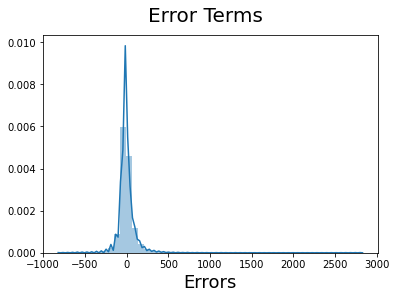

In [50]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 50)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

In [51]:
#Dividing into X and y
y_test = y_valid
X_test = OH_X_valid

In [52]:
# Now let's use our model to make predictions.
X_train_new = best_X_train.drop('const',axis=1)
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [53]:
# Making predictions
y_pred = lm.predict(X_test_new)

In [54]:
# Scoring the model
from sklearn.metrics import r2_score 
r2_score(y_test, y_pred)

0.8378729877480156

Text(0, 0.5, 'y_pred')

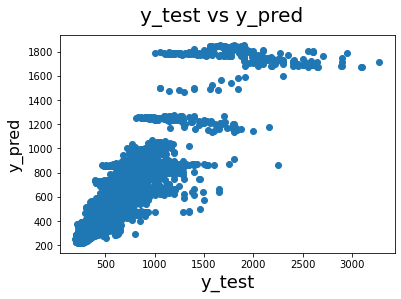

In [55]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)

In [56]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     7080.
Date:                Sun, 06 Sep 2020   Prob (F-statistic):               0.00
Time:                        05:35:13   Log-Likelihood:            -4.8463e+05
No. Observations:               79964   AIC:                         9.694e+05
Df Residuals:                   79906   BIC:                         9.699e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------